# Evaluating Model Trustworthiness

With Machine Learning becoming more and more prominent in performance critical tasks such as medicine or threat appraisal. We want to create a way to explain the predictions of a model so we, and domain experts, can have a way to understand the reasons behind a prediction to evaluate model and prediction trustworthiness.

## Criteria for explainability

1. Human understandable. Explanation space must be understandable by a human
2. Local Fidelity - For an explanation to actually explain model behavior, then it must be locally faithful to the model being explained
3. Model Agnostic - Can perform the same explanation procedure for any model

We want  Local Interpretable Model-agnostic Explanations which we will call **LIME**

![Local Fidelity](local_fidelity.png)

# Explain Your Predictive Models to Business Stakeholders using LIME with Python and Xgboost
#### Describing complex models and generating reason codes with Local Interpretable Model-agnostic Explanations (LIME) and LIME-variants

Local Interpretable Model-agnostic Explanations (LIME) shed light on how almost any machine learning model makes decisions for specific rows of data. LIME builds local linear surrogate models around observations of interest and leverages the highly interpretable properties of linear models to increase transparency and accountability for the corresponding model predictions. In this notebook, a xgboost GBM is trained on the UCI credit card default data and then predictions for a highly risky customer are explained using linear model coefficients and LIME-derived reason codes. The notebook concludes by introducing a variant of LIME that is easier to execute on new data and that can be analyzed alongside observed (i.e., not simulated) data.

In [1]:
import xgboost as xgb

import operator # for sorting dictionaries

import numpy as np   # array, vector, matrix calculations
import pandas as pd  # DataFrame handling
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
import category_encoders as ce
# display plots in notebook
%matplotlib inline

## 1. Download, explore, and prepare UCI credit card default data

UCI credit card default data: https://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients

The UCI credit card default data contains demographic and payment information about credit card customers in Taiwan in the year 2005. The data set contains 23 input variables: 

* **`LIMIT_BAL`**: Amount of given credit (NT dollar)
* **`SEX`**: 1 = male; 2 = female
* **`EDUCATION`**: 1 = graduate school; 2 = university; 3 = high school; 4 = others 
* **`MARRIAGE`**: 1 = married; 2 = single; 3 = others
* **`AGE`**: Age in years 
* **`PAY_0`, `PAY_2` - `PAY_6`**: History of past payment; `PAY_0` = the repayment status in September, 2005; `PAY_2` = the repayment status in August, 2005; ...; `PAY_6` = the repayment status in April, 2005. The measurement scale for the repayment status is: -1 = pay duly; 1 = payment delay for one month; 2 = payment delay for two months; ...; 8 = payment delay for eight months; 9 = payment delay for nine months and above. 
* **`BILL_AMT1` - `BILL_AMT6`**: Amount of bill statement (NT dollar). `BILL_AMNT1` = amount of bill statement in September, 2005; `BILL_AMT2` = amount of bill statement in August, 2005; ...; `BILL_AMT6` = amount of bill statement in April, 2005. 
* **`PAY_AMT1` - `PAY_AMT6`**: Amount of previous payment (NT dollar). `PAY_AMT1` = amount paid in September, 2005; `PAY_AMT2` = amount paid in August, 2005; ...; `PAY_AMT6` = amount paid in April, 2005. 

These 23 input variables are used to predict the target variable, whether or not a customer defaulted on their credit card bill in late 2005.

#### Import data and clean
The credit card default data is available as an `.xls` file. Pandas reads `.xls` files automatically, so it's used to load the credit card default data and give the prediction target a shorter name: `DEFAULT_NEXT_MONTH`.

In [2]:
# import XLS file
path = 'default_of_credit_card_clients.xls'
data = pd.read_excel(path,
                     skiprows=1)

# remove spaces from target column name 
data = data.rename(columns={'default payment next month': 'DEFAULT_NEXT_MONTH'}) 

#### Assign modeling roles
The shorthand name `y` is assigned to the prediction target. `X` is assigned to all other input variables in the credit card default data except the row indentifier, `ID`.

In [3]:
# assign target and inputs for GBM
y = 'DEFAULT_NEXT_MONTH'
X = [name for name in data.columns if name not in [y, 'ID']]
categorical_columns = ['SEX', 'EDUCATION', 'MARRIAGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']
print('y =', y)
print('X =', X)
print('categorical =', categorical_columns)

y = DEFAULT_NEXT_MONTH
X = ['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']
categorical = ['SEX', 'EDUCATION', 'MARRIAGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']


In [4]:
data[X].head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
0,20000,2,2,1,24,2,2,-1,-1,-2,...,689,0,0,0,0,689,0,0,0,0
1,120000,2,2,2,26,-1,2,0,0,0,...,2682,3272,3455,3261,0,1000,1000,1000,0,2000
2,90000,2,2,2,34,0,0,0,0,0,...,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000
3,50000,2,2,1,37,0,0,0,0,0,...,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000
4,50000,1,2,1,57,-1,0,-1,0,0,...,35835,20940,19146,19131,2000,36681,10000,9000,689,679


We map the rarer education cases to other

In [5]:
education_map_series = pd.Series(index=[0,1,2,3,4,5,6], data=[0,1,2,3,0,0,0])
data['EDUCATION'] = data['EDUCATION'].map(education_map_series)

## 2. Train a Xgboost classifier

#### Split data into training and test sets for early stopping
The credit card default data is split into training and test sets to monitor and prevent overtraining. Reproducibility is also an important factor in creating trustworthy models, and randomly splitting datasets can introduce randomness in model predictions and other results. A random seed is used here to ensure the data split is reproducible.

In [6]:
# split into training and validation
X_train, X_test, y_train, y_test = train_test_split(data, data[y], test_size=0.3, random_state=123146)

# summarize split
print('Train data rows = %d, columns = %d' % (X_train.shape[0], X_train.shape[1]))
print('Test data rows = %d, columns = %d' % (X_test.shape[0], X_test.shape[1]))

Train data rows = 21000, columns = 25
Test data rows = 9000, columns = 25


#### Train Xgboost GBM classifier
Many tuning parameters must be specified to train a GBM using xgboost. Typically a grid or random search would be performed to identify the best parameters for a given modeling task. For brevity's sake, a previously-discovered set of good tuning parameters are specified here. Because gradient boosting methods typically resample training data, an additional random seed is also specified for the xgboost GBM using the `seed` parameter to create reproducible predictions, error rates, and variable importance values. To avoid overfitting, the `early_stopping_rounds` parameter is used to stop the training process after the test error fails to decrease for 5 iterations.

In [7]:
# initialize GBM model
model = xgb.XGBClassifier(n_estimators=150,            # maximum 150 trees in GBM
                                     max_depth=4,           # trees can have maximum depth of 4
                                     subsample=0.9,       # use 90% of rows in each iteration (tree)
                                     colsample_bylevel=0.9,   # use 90% of variables in each iteration (tree)
                                     seed=12345)            # random seed for reproducibility

ohe = ce.OneHotEncoder(cols = categorical_columns)

# train a GBM model
model.fit(ohe.fit_transform(X_train[X]), y_train, eval_set=[(ohe.transform(X_test[X]), y_test)], early_stopping_rounds=5, eval_metric='auc')

# print AUC
print('GBM Test AUC = %.2f' % model.best_score)

[0]	validation_0-auc:0.730749
Will train until validation_0-auc hasn't improved in 5 rounds.
[1]	validation_0-auc:0.733143
[2]	validation_0-auc:0.75398
[3]	validation_0-auc:0.759447
[4]	validation_0-auc:0.759956
[5]	validation_0-auc:0.762471
[6]	validation_0-auc:0.764078
[7]	validation_0-auc:0.764985
[8]	validation_0-auc:0.765814
[9]	validation_0-auc:0.766707
[10]	validation_0-auc:0.767137
[11]	validation_0-auc:0.768194
[12]	validation_0-auc:0.768591
[13]	validation_0-auc:0.769188
[14]	validation_0-auc:0.769071
[15]	validation_0-auc:0.76959
[16]	validation_0-auc:0.769381
[17]	validation_0-auc:0.771053
[18]	validation_0-auc:0.771088
[19]	validation_0-auc:0.770905
[20]	validation_0-auc:0.773108
[21]	validation_0-auc:0.774344
[22]	validation_0-auc:0.774926
[23]	validation_0-auc:0.776048
[24]	validation_0-auc:0.776556
[25]	validation_0-auc:0.77699
[26]	validation_0-auc:0.777183
[27]	validation_0-auc:0.777483
[28]	validation_0-auc:0.777883
[29]	validation_0-auc:0.778283
[30]	validation_0-au

## 3. Use LIME to generate descriptions for a local region with a perturbed sample

LIME was originally described in the context of explaining image or text classification decisions here: http://www.kdd.org/kdd2016/papers/files/rfp0573-ribeiroA.pdf. It can certainly also be applied to business or customer data, as will be done in the remaining sections of this notebook. Multiple Python implementations of LIME are available from the original authors of LIME, from the eli5 package, from the skater package, and probably others. However, this notebook uses a simple, step-by-step implementation of LIME for instructional purposes. 

A linear model cannot be built on a single observation, so LIME typically requires that a set of rows similar to the row of interest be simulated. This set of records are scored using the complex model to be explained. Then the records are weighted by their closeness to the record of interest, and a regularized linear model is trained on this weighted explanatory set. The parameters of the linear model and LIME-derived reason codes are then used to explain the prediction for the selected record. Because simulation of new points can seem abstract to some practicioners and simulation and distance calculations can be somewhat burdensome for creating explanations quickly in mission-critical applications, this notebook also presents a variation of LIME in which a more practical sample, instead of a perturbed, simulated sample, is used to create a local region in which to fit a linear model.

#### Display the most risky customer
In the Oriole notebook *Increase Transparency and Accountability in Your Machine Learning Project with Python and H2O*, row index 29116 was found to contain the riskiest customer in the test dataset according to the xgboost GBM model. Sections 3-7 focus on deriving reason codes and other explanations for this customer's GBM prediction. The riskiest customer is selected first for analysis as an exercise in boundary testing.

In [8]:
row = X_test.loc[29115]
row

ID                    29116
LIMIT_BAL             20000
SEX                       2
EDUCATION                 2
MARRIAGE                  1
AGE                      59
PAY_0                     3
PAY_2                     2
PAY_3                     3
PAY_4                     2
PAY_5                     2
PAY_6                     4
BILL_AMT1              8803
BILL_AMT2             11137
BILL_AMT3             10672
BILL_AMT4             11201
BILL_AMT5             12721
BILL_AMT6             11946
PAY_AMT1               2800
PAY_AMT2                  0
PAY_AMT3               1000
PAY_AMT4               2000
PAY_AMT5                  0
PAY_AMT6                  0
DEFAULT_NEXT_MONTH        1
Name: 29115, dtype: int64

To use LIME, a sample of similar (i.e., near or local) points is simulated around the customer of interest. This simple function draws numeric values from normal distributions centered around the customer of interest and draws categorical values at random from the variable values in the test set.

In [9]:
def generate_local_sample(row, frame, X, N=1000):
    
    """ Generates a perturbed sample around a row of interest.
    
    Args:
        row: Row of DataFrame to be explained.
        frame: DataFrame in which row is stored.
        X: List of model input variables.
        N: Number of samples to generate.
    
    Returns:
        Pandas DataFrame containing perturbed sample.
    
    """
    
    # initialize Pandas DataFrame
    sample_frame = pd.DataFrame(data=np.zeros(shape=(N, len(X))), columns=X)
    
    # generate column vectors of 
    # randomly drawn levels for categorical variables
    # normally distributed numeric values around mean of column for numeric variables
    for key, val in frame[X].dtypes.items():
        if key in categorical_columns:
            rs = np.random.RandomState(11111) # random seed for reproducibility
            draw = rs.choice(frame[key].unique(), size=(1, N))[0]
        else:
            rs = np.random.RandomState(11111) # random seed for reproducibility
            loc = row[key]
            sd = frame[key].std()
            draw = rs.normal(loc, sd, (N, 1))
            draw[draw < 0] = loc # prevents unrealistic values when std. dev. is large
        
        sample_frame[key] = draw
        
    return sample_frame

# run and display results
perturbed_sample = generate_local_sample(row, X_test, X)
perturbed_sample.head(n=3)

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
0,10025.186811,1,1,2,58.283411,-2,3,3,7,7,...,5485.849040,6296.772616,8067.580477,7374.519622,1458.599409,0.00000,1000.000000,981.206720,0.00000,0.000000
1,180448.783867,2,3,1,70.526623,6,6,5,8,6,...,94093.273032,90087.421702,87573.078836,85480.055545,24376.954818,20063.39376,22297.264073,18387.689649,19770.41373,25239.055114
2,20000.000000,2,0,0,43.193819,3,7,8,5,7,...,10672.000000,11201.000000,12721.000000,11946.000000,2800.000000,0.00000,1000.000000,2000.000000,0.00000,0.000000


#### Calculate distance between row of interest and perturbed sample
Once the sample is simulated, then distances from the point of interest are used to weigh each point before fitting a penalized regression model. Since Euclidean distance calculations require numeric quanitites, categorical input variables are one-hot encoded. (Pandas has convenient functionality for one-hot encoding. To prevent the disparate scales of numeric values, such as `AGE` and `LIMIT_BAL`, from  skewing Euclidean distances, numeric input variables are standardized. 

First, the row containing the riskiest customer is encoded and standardized.

In [10]:
# scaling and one-hot encoding for calculating Euclidian distance
# for the row of interest

# scale numeric
numeric = list(set(X) - set(['ID', 'SEX', 'EDUCATION', 'MARRIAGE', 'PAY_0', 'PAY_2',
                             'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'DEFAULT_NEXT_MONTH']))

scaled_test = X_test.copy(deep=True)
scaled_test[numeric] = (scaled_test[numeric] - scaled_test[numeric].mean())/scaled_test[numeric].std()
    
# encode categorical
row_df = scaled_test[scaled_test['ID'] == 29116]
row_dummies = pd.concat([row_df.drop(['ID', 'SEX', 'EDUCATION', 'MARRIAGE', 'PAY_0', 'PAY_2',
                                      'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'DEFAULT_NEXT_MONTH'], axis=1),
                        pd.get_dummies(row_df[categorical_columns], columns=categorical_columns)], 
                        axis=1)

row_dummies

,LIMIT_BAL,AGE,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,...,PAY_AMT6,SEX_2,EDUCATION_2,MARRIAGE_1,PAY_0_3,PAY_2_2,PAY_3_3,PAY_4_2,PAY_5_2,PAY_6_4
29115,-1.142884,2.535411,-0.578047,-0.538289,-0.530678,-0.50159,-0.453643,-0.450628,-0.169373,-0.351352,...,-0.275956,1,1,1,1,1,1,1,1,1


Then the simulated sample is encoded and standardized.

In [11]:
# scaling and one-hot encoding for calculating Euclidian distance 
# for the simulated sample

# scale
scaled_perturbed_sample = perturbed_sample[numeric].copy(deep=True)
scaled_perturbed_sample = (scaled_perturbed_sample - scaled_perturbed_sample.mean())/scaled_perturbed_sample.std()

# encode
perturbed_sample_dummies = pd.concat([scaled_perturbed_sample,
                                      pd.get_dummies(perturbed_sample[categorical_columns], columns=categorical_columns)],
                                     axis=1)

perturbed_sample_dummies = perturbed_sample_dummies[row_dummies.columns]
perturbed_sample_dummies.head(3)

,LIMIT_BAL,AGE,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,...,PAY_AMT6,SEX_2,EDUCATION_2,MARRIAGE_1,PAY_0_3,PAY_2_2,PAY_3_3,PAY_4_2,PAY_5_2,PAY_6_4
0,-0.845634,-0.095570,-0.849790,-0.844709,-0.844709,-0.838860,-0.834367,-0.834967,-0.843766,-0.723503,...,-0.723503,0,0,0,0,0,1,0,0,0
1,1.419026,1.201095,1.419485,1.418916,1.418916,1.418204,1.417602,1.417686,1.418803,1.419987,...,1.419987,1,0,1,0,0,0,0,0,0
2,-0.713084,-1.693692,-0.716971,-0.712220,-0.712220,-0.706755,-0.702560,-0.703120,-0.711339,-0.723503,...,-0.723503,1,0,0,1,0,0,0,0,0


Distance is calculated using the L2 Distance Metric. The distance is substracted from the maximum distance, changing the distance values into similarity values. Now the observations with the highest values are those that are closest to the observation of interest and they will carry the most weight in the local explanatory linear model. A few sample similarity values are displayed directly below.

In [12]:
distance = np.square(perturbed_sample_dummies.get_values() - row_dummies.get_values()).sum(axis=1)
distance = np.max(distance) - distance 
distance = pd.Series(distance)
distance.head(3)

0    299.638365
1    262.373006
2    290.316924
dtype: float64

In [13]:
positive_preds = model.predict_proba(ohe.transform(perturbed_sample))[:, 1]

#### Bind model predictions onto perturbed sample
For LIME, the target of the explanatory local linear model is the predictions of the GBM model in the local simulated sample. The values are calculated and column-bound to the simulated sample. 

In [14]:
local_glm1 = Ridge(alpha=1.7)
l = ce.OneHotEncoder(cols=categorical_columns)
train = l.fit_transform(perturbed_sample[X])
local_glm1.fit(train, positive_preds, distance)

# coefs
print('\nLocal Positive GLM Coefficients:')
for c_name, c_val in sorted(zip(train.columns, local_glm1.coef_), key=operator.itemgetter(1), reverse=True):
    if c_val > 0.0:
        print('%s %s' % (str(c_name + ':').ljust(25), f'{c_val:.20f}'))
        
# r2
print('\nLocal GLM R-square:\n%.2f' % local_glm1.score(train, positive_preds, distance))


Local Positive GLM Coefficients:
PAY_2_6:                  0.08509314876807738681
PAY_3_6:                  0.08509314876791396198
PAY_4_6:                  0.08509314876777182568
PAY_0_6:                  0.08509314876741490286
PAY_6_5:                  0.03356932266976577622
PAY_5_5:                  0.03356932266930789249
EDUCATION_2:              0.02084472399056211747
MARRIAGE_2:               0.02084472399055155648
PAY_5_3:                  0.01870049530985361599
PAY_6_3:                  0.01870049530976955823
SEX_1:                    0.01043244173642951349
EDUCATION_4:              0.00869131437123876055
MARRIAGE_4:               0.00869131437108523405
EDUCATION_1:              0.00174112737349656687
MARRIAGE_1:               0.00174112737324872888
PAY_6_9:                  0.00056059284986672046
PAY_5_9:                  0.00056059284963558807
PAY_AMT6:                 0.00004202050844011086
PAY_AMT2:                 0.00003366794811838463
PAY_AMT5:                 0.0000326

#### Train penalized linear model in local region 
Once the simulated sample has been weighted with distances and contains the GBM model predictions, a linear model is fit to the original inputs and the GBM model predictions, weighted by similarity to the row of interest. The trained GLM coefficients are helpful for understanding the local region of response function around the riskiest customer.

The coefficients of the local linear model describe the average behavior of the GBM response function around the riskiest customer. In this local region, customers who missed payments, particularly `PAY_2`, `BILL_AMT3`, and `PAY_AMT2`, are treated as the most likely to default.

## 4. Generate reason codes with LIME based on a perturbed sample
This basic function uses the coefficients of the local linear explanatory model and the values in the row of interest to plot reason code values in a bar chart. The local GLM coefficient multiplied by the value in a specific row are estimates of how much each variable contributed to each prediction decision. These values can tell you how a variable and its values were weighted in any given decision by the model. These values are crucially important for machine learning interpretability and are often to referred to "local feature importance", "reason codes", or "turn-down codes." The latter phrases are borrowed from credit scoring. Credit lenders in the U.S. must provide reasons for turning down certain credit applications in an automated fashion. Reason codes can be easily extracted from LIME local feature importance values by simply ranking the variables that played the largest role in any given decision.

In [15]:
def plot_local_contrib(row, model, encoded_columns): 

    """ Plots reason codes in a bar chart. 
    
    Args:
    
        row: Row of Data Frame to be explained.
        model: Ridge linear model used for generating reason codes.
    
    """
    coefs = dict(zip(encoded_columns, model.coef_))
    # initialize Pandas DataFrame to store results
    local_contrib_frame = pd.DataFrame(columns=['Name', 'Local Contribution', 'Sign'])
    
    # multiply values in row by local glm coefficients    
    for key in sorted(row.index):
        contrib = 0
        name = ''
        if key in categorical_columns:
            level = row[key]
            name = '_'.join([str(key), str(level)])
        
            if name in coefs:
                contrib = coefs[name]
        else:
            name = key
            if name in coefs:
                contrib = row[name]*coefs[name]
        
        # save only non-zero values
        if contrib != 0.0:
            local_contrib_frame = local_contrib_frame.append({'Name': name,
                                                              'Local Contribution': contrib,
                                                              'Sign': contrib > 0}, 
                                                             ignore_index=True) 
    
    # plot
    _ = local_contrib_frame.plot(x='Name',
                                 y='Local Contribution',
                                 kind='bar', 
                                 title='Reason Codes', 
                                 color=local_contrib_frame.Sign.map({True:'b', False:'g'}), 
                                 legend=False) 
    

#### Display reason codes
Here it can be seen that the riskiest customer's prediction is driven by her values for payment variables. Specifically, the top five LIME-derived reason codes contributing to her high probability of default are:

1. Most recent payment is 3 months delayed.
2. 2nd most recent payment is 2 months delayed.
3. 3rd most recent payment is 3 months delayed.
4. Customer Age is 59.
5. 4th most recent payment is 2 months delayed.

(Of course, in many places, variables like `MARRIAGE`, `AGE`, and `SEX` cannot be used in credit lending decisions.)

This result is somewhat aligned with LOCO-derived reason codes found in section 5 of the *Increase Transparency and Accountability in Your Machine Learning Project with Python and H2O* Oriole notebook. Both perspectives weigh the riskiest customer's most recent and 3rd most recent payments very heavily in the model's prediction. A minor discrepancy between LOCO- and LIME-derived reason codes is somewhat expected. LIME explanations are linear, do not consider interactions, and represent offsets from the local linear model intercept. LOCO importance values are nonlinear, do consider interactions, and do not explicitly consider a linear intercept or offset. **Because most currently-available explanatory techniques are approximate, it is recommended that users employ several different explanatory techniques and trust only consisent results across techniques.**

It is also imperative to compare these results to domain knowledge and reasonable expectations. In this case, the LIME reason codes and linear model coefficients tell a relatively parsimonious story about the GBM's prediction behavior. If this was not so, steps should be taken to either reconcile or remove inconsistencies and unreasonable predictions.

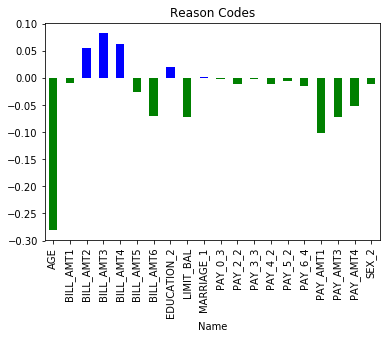

In [16]:
plot_local_contrib(row, local_glm1, train.columns)

## 5. Use LIME to generate descriptions for a local region with a practical sample
Using a previously-existing local sample based on clusters, deciles, or other more natural segments to create LIME explanations is computationally cheaper and perhaps more straightforward than using a simulated perturbed sample, but it does have one major drawback. If the sample is too large, the explanatory linear model maybe not be accurate enough to explain all predictions in the sample. The remaining sections of this notebook will explore the idea of generating LIME explanations using a practical sample. 

#### Create a local region based on values of SEX and merge with GBM model predictions
Instead of using a perturbed simulated sample, a linear model will be fit on all women in the test set, and the sample is not weighted by distance from any one point. A few lines of the all female sample are displayed directly below.

In [17]:
practical_sample = X_test[X]
practical_sample = practical_sample[practical_sample['SEX'] == 2]
preds2 = model.predict_proba(ohe.transform(practical_sample))[:, 1]
practical_sample.head(3)

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
23299,340000,2,3,1,32,0,-1,0,0,0,...,59375,60216,59842,46882,57301,3000,2600,1000,1817,11022
4008,130000,2,2,2,24,1,-2,-2,-2,-2,...,0,0,0,0,0,0,0,0,0,0
897,170000,2,1,2,28,2,2,2,2,2,...,129761,138604,136283,145012,5600,0,11000,0,11000,5656


#### Train penalized linear model in local region 
A penalized linear model is trained in the local region defined by women in the test set. Because fit is a concern in this much larger explanatory sample, users should always check the R<sup>2</sup> or other goodness-of-fit measures to ensure surrogate model is accurate in the sample. 

In [18]:
# initialize
local_glm2 = Ridge()
l2 = ce.OneHotEncoder(cols=categorical_columns)
train_2 = l2.fit_transform(practical_sample[X])

# train 
local_glm2.fit(train_2, preds2)

# coefs
print('\nLocal Positive GLM Coefficients:')
for c_name, c_val in sorted(zip(train_2.columns, local_glm2.coef_), key=operator.itemgetter(1)):
    if c_val > 0.0:
        print('%s %s' % (str(c_name + ':').ljust(25), f'{c_val:.20f}'))
        
# r2
print('\nLocal GLM R-square:\n%.2f' % local_glm2.score(train_2, preds2))


Local Positive GLM Coefficients:
BILL_AMT2:                0.00000003079127522292
PAY_AMT5:                 0.00000006505336401613
BILL_AMT5:                0.00000015720273832600
BILL_AMT3:                0.00000017521869483405
AGE:                      0.00052713415053799468
PAY_4_1:                  0.00067429227552732475
PAY_3_4:                  0.00122537522471141409
PAY_5_6:                  0.00174911150962737223
MARRIAGE_2:               0.00184437770990423622
EDUCATION_3:              0.00635317067663951525
MARRIAGE_1:               0.00726725968500083544
PAY_6_8:                  0.00787699676993150813
PAY_4_2:                  0.00892728349643124967
EDUCATION_1:              0.00929273010226147958
PAY_0_9:                  0.00936665202847812746
PAY_2_8:                  0.00936665202847817603
MARRIAGE_3:               0.01089818751059745683
EDUCATION_2:              0.01190415143635286874
PAY_5_3:                  0.01275215136740192635
PAY_5_8:                  0.0146446

The R<sup>2</sup> is quite high for this local sample and linear model. Because the sample is simply the women in the test set and because the model fit is acceptable, the trained linear model and coefficients can be used to understand the average behavior of women in the test set. On average, late payments, particulary `PAY_0`, `PAY_2`, and `PAY_6`, are the most likely to push the GBM model towards higher probability of default values for women.

## 6. Generate a ranked predictions plot to assess validity of local explanatory model
A *ranked predictions plot* can also be used to ensure the local linear surrogate model is a good fit for the model inputs and predictions. A ranked predictions plot is a way to visually check whether the surrogate model is a good fit for the complex model. The y-axis is the numeric prediction of both models for a given point. The x-axis is the rank of a point when the predictions are sorted by their GBM prediction, from lowest on the left to highest on the right. When both sets of predictions are aligned, as they are below, this a good indication that the linear model fits the complex, nonlinear GBM well in the practical sample.

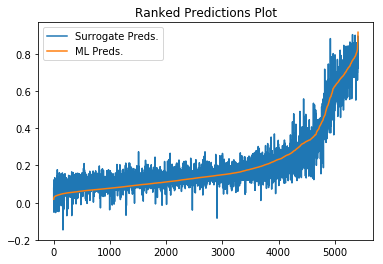

In [19]:
# ranked predictions plot
local_glm2_preds = local_glm2.predict(train_2)
pred_frame = pd.DataFrame({'Surrogate Preds.': local_glm2_preds, 'ML Preds.': preds2})

pred_frame.sort_values(by='ML Preds.', inplace=True)
pred_frame.reset_index(inplace=True, drop=True)
_ = pred_frame.plot(title='Ranked Predictions Plot')

Both the R<sup>2</sup> and ranked predictions plot show the linear model is a good fit in the practical, approximately local sample. This means the regression coefficients are likely a very accurate representation of the behavior of the nonlinear model in this region.

## 7. Generate reason codes using a practical sample

#### Create explanations (or 'reason codes') for a row in the local set
Reason codes are generated for the model based on the practical sample, just as they were for the model based on the perturbed sample. Again, the woman's value for `PAY_0` is the most important local contributor to her GBM prediction. As seen in other attempts to explain this prediction, `PAY_0` followed by other payment variables, marital status, and her age play a role in the model decision. 

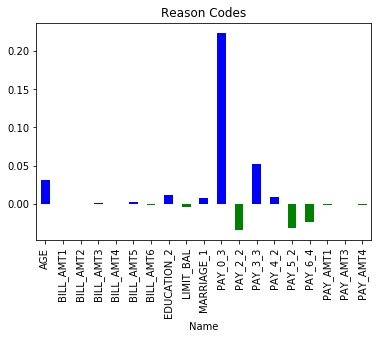

In [20]:
plot_local_contrib(row, local_glm2, train_2.columns)                                                             

#### Summary
In this notebook, LIME was used to explain and generate reason codes for a complex GBM classifier. To do so, local linear models were fit to appropriate, representative samples and linear model coefficients were used to explain the average behavior in the samples and to create reason codes. Reason codes were assesed against domain knowledge and reasonable expectations. A ranked prediction plot was also introduced to compare surrogate linear model predictions to GBM model predictions. These techniques should generalize well for many types of business and research problems, enabling you to train a complex machine learning model and analyze, validate, and explain it to your colleagues, bosses, and potentially, external regulators.